# Final Project: Estimating the Hurst Parameter with Visibility Graphs to measure Long Memory in Time Series

**Author**: Joseph Dasenbrock

**Abstract**

Time series analysis is dominated by the class of ARMA models, which model future values of the series as function of recent past values of the series. While these models have been successful in application, ARMA models have limitations founded in the assumptions being made about the nature of the underlying process. Time series analysis based on graphs (i.e. networks) offer potential for modeling which makes less strict assumptions, and opens up time series analysis to the rich mathematical toolset available to networks. The visibility graph is introduced and explored as one way to model a time series as a network. To exemplify the utility of such a model, the visibility graph is applied to the analysis of long memory in time series. A time series which possesses long memory is one which is significantly dependent on the entirety of the history of the series, not just the most recent values. Long memory is introduced and visibility graphs are utilized to estimate the Hurst parameter and differentiate between simulated time series which exhibit long memory and series that do not exhibit such as property.

# Introduction



Among the most common tools for time series analysis is the AutoRegressive Moving Average model (ARMA). This class of models treats a time series as random process where future values are dependent on some small number of recent values of the series itself plus some number of recent values of the "white noise" in the time series. There are many different forms and variants of such models, however below is one common form ([1]): 

$$
\def \a {\alpha}
r_t = \phi_0 + \sum_{i=1}^{p} \phi_i r_{t-i} + \a_{t} - \sum_{i=1}^{q}\theta_i \a_{t-i}
$$

...where $p$ and $q$ are nonnegative integers, $r_i$ is the time series, and $\{\alpha_i\}$ is a white noise series derived from the time series.

To explain the above equation in words, the current value $r_t$ of the series is a function of a set of weights $\phi$, the most recent values of the series itself $r$, another set of weights $\theta$, and the most recent values of the white noise series $\alpha$.

Translation of a time series into a graph (network) would offer advantages over the ARMA model as described here - a network would likely capture more of the idiosyncratic features of the data itself, instead of requiring the data to be modeled as a function of a few recent values. Also, translation of the series to a graph would make available the rich mathematical toolset available to graphs, and therefore more useful information could be extracted from the data. 

# Visibility Graphs



One such method of translating a time series into a network is a "visibility graph", which will be explored in this notebook. Lacasa et al 2008 [5] provides a useful introduction to the visibility graph. In this section, the example given in the Lacasa paper will be implemented in code and the results will be demonstrated. 

[1]:https://dx.doi.org/10.1073/pnas.0709247105

Borrowing from first page of the the Lacasa paper [5], a visibility graph is a graph created from a time series where two values of the time series are connected if there is "visibility" between them. Conceptually, this means that two points are connected if one can be seen from the other without obstruction from some middle value of the time series. 

Mathematically, two points of the time series $(t_a, y_a)$, $(t_b, y_b)$ are connected in the visibility graph if, for any other data point $(t_c, y_c)$, there is: 

$$
y_c < + \left( y_a - y_b \right)\frac{t_b-t_c}{t_b-t_a} \qquad\textbf{(1)}
$$

...which corresponds to equation $\textbf{(1)}$ in Lacasa 2008 [5]. 

Now, we will replicate the simple time series presented in the first page of Lacasa 2008 [5], using a python module that has been written by the author.

We will use `numpy` and `matplotlib`:

In [1]:
import numpy as np
from matplotlib import pyplot as plt

...and the time series from Lacasa 2008 [6] is created below:

In [2]:
# create data from lacasa paper
y = [87,49,36,83,]*5
y = np.array([x/100 for x in y]) 
n = len(y)
x = np.array(range(n)) 

..and now we will use a custom function (available in folder `src`) to create a plot:

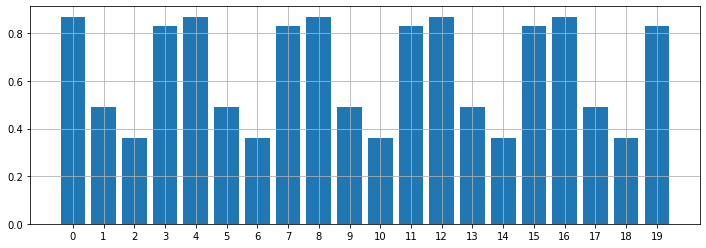

In [3]:
# import helper function used to create graph
from src import helpers 
fig = helpers.intro_plot(x, y)

Now that the time series data is loaded, we will use another function to translate the time series into a visibility graph. The module `build_visibility_graph` (located in `src`) is loaded below and aliased as `create_graph`.

In [4]:
from src import build_visibility_graph as create_graph 

The code can be viewed by [clicking on this link](src/build_visibility_graph.py) or by using the "?" cell operator like this:

In [5]:
?create_graph.create_edges

The function `create_edges` from this module is used to create edges from `x` and `y`. This is accomplished by applying the inequality $\textbf{(1)}$ across every pair of points in the time series, i.e. the inequality is applied for every $(x_i, y_i)$, $(x_j, y_j)$ and for every $(x_c, y_c)$ between. If at any point the inequality fails to hold, no edge is created and the next pair is evaluated. 

Now we create the edges using the module and then graph the result:

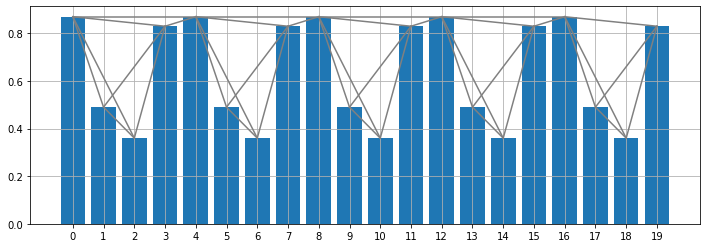

In [6]:
# create edges for network 
edges = create_graph.create_edges(x, y)

# plot the series with the edges
fig = helpers.intro_plot(x, y, edges=edges)

As pointed out in Lacasa 2008 [5], an interesting and potentially useful property of a visibility graph is that the resulting graph is invariant to scale, i.e. the time series scaled by a factor yields the same visibility graph.

This can be demonstrated by multiplying the $y$ value of the series and multiplying it by a factor, and then comparing the scaled version of the graph with the original.

To demonstrate, we first record the original set of edges as `EDGES_BASE`:

In [7]:
# record the base edges 
EDGES_BASE = list(edges)

...and then use a function that compare `EDGES_BASE` with edges created from a scaled version of the graph, and will raise an `Exception` if the resulting graph is different:

In [8]:
def plot_adjusted(x, y, scale, plot=True, assertion=True):
    """Scales the input data by factor `scale`, compares to original
    
    Creates a barplot similar to previous plot, asserts that edges are 
    the same as EDGES_BASE (i.e. will raise error if not
    exactly the same).
    
    """
    global EDGES_BASE
    # multiply every value in y by the scalar
    y_adj = [i*scale for i in y]
    # create the visibility graph from the scaled edges
    edg = create_graph.create_edges(x, y_adj)
    
    # check that the outcome is the same as EDGES_BASE, if not raise an error
    f = lambda x: list(sorted(x))
    if assertion:
        msg = (f'Edge sets should be the same, scale={scale}. Expected '
               f'edges {EDGES_BASE}, calculated {edg}')
        assert f(edg) == f(EDGES_BASE), msg
    
    # plot the new graph
    if plot:
        fig = helpers.intro_plot(x, y_adj, edges=edg)

In other words, using function `plot_adjusted`, we can scale the data by different scalars by passing different arguments to test if the resulting set of edges is the same, and we can plot the result to review visually.

We scale by a factor of $2$ below:

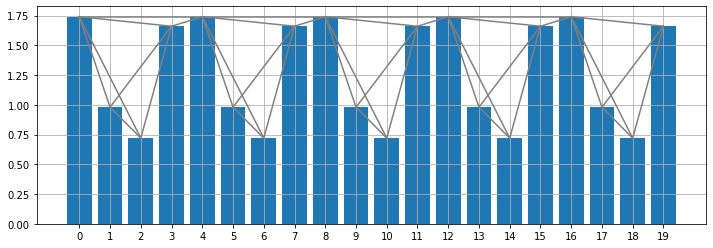

In [9]:
plot_adjusted(x, y, 2)

...and we can see that the $y$ values doubled, and the function completed without raising an `AssertionError`, therefore the visibility graphs are the same. 

We can also test a larger number of graphs (skipping the plots in this case):

In [10]:
for sc in np.linspace(2, 1000, 25):
        plot_adjusted(x, y, sc, plot=False)

for sc in np.linspace(0.01, 1, 25):
        plot_adjusted(x, y, sc, plot=False)

Below is a simple widget that allows for inputting different scale values and automatically applying the `plot_adjusted` function:

In [11]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from warnings import warn

In [12]:
@interact
def adjusted_plot_interactive(scale='1e6'):
    global x
    global y
    if scale == '':
        return plot_adjusted(x, y, 1)
    else:
        try:
            scale = float(scale)
        except Exception as e:
            msg = (f'Error when trying to convert "scale" to float, '
                   f'is it numeric? Received "{scale}".') 
            warn(msg)
            raise Exception(msg)
        if not float(scale) > 0:
            msg = f'Scale must be greater than 0, received "{scale}".'
            warn(msg)
            raise Exception(msg)
            
        return plot_adjusted(x, y, float(scale))

interactive(children=(Text(value='1e6', description='scale'), Output()), _dom_classes=('widget-interact',))

Different scalars can be used by changing the value in the textbox "scale" (values update automatically). 

# Fractional Brownian Motion and the Hurst Parameter

In this section, we will showcase one potential application of visibility graphs, related to Fractional Brownian Motion and the Hurst parameter. The Hurst parameter quantifies the level of *long-range dependence* in a time series. 

A time series with long range dependence is one which exhibits a "non-negligible dependence between the present and all points in the past." (Graves et al, 2017 [3]). An early observation of this type of process in nature was made by a civil engineer named Harold Edwin Hurst, who was tasked with the design of dams for water control in the Nile basin for the Egyptian government in the first part of the 20th century (Graves et al, 2017 [3]). 

Hurst found the importance of long memory when studying the optimal reservoir capacity for a man-made reservoir, which is equivalent to choosing the height of the dam that creates the reservoir. The ideal height of a dam is a height that achieves the minimum water capacity so that the reservoir has stable outflow and level. Prior to Hurst, a simulation approach using independent Gaussian processes had been among the best solutions to this dam height problem (Graves et al, 2017 [3]).

Hurst was able to show that independent Gaussian processes used in models at the time did not adequately explain a large amount of empirical hydrological data, and suggested that the assumption that the process is Gaussian-independent was incorrect (Graves et al, 2017 [3]).

While Hurst is widely credited with an early observation of long-range dependence, Mandelbrot played a larger role in utilizing and developing the concept. In a 1968 paper, Mandelbrot proposed *Fractional Brownian Motion*, which is related to both Hurst's hydrological model and to Brownian Motion, which was gaining attention in the literature on financial prices at the time (Graves et al, 2017 [3], Mandelbrot & Ness, 1968 [6], Bachelier, 1900 [1]). 

Fractional Brownian Motion was defined as follows in the 1968 paper:

>**Fractional Brownian Motion** (Mandelbrot & Ness, 1968 [6]). Let $H$ be a number such that $0<H<$, and let $b_0$ be a real number. The function $B_{H}(t, \omega)$ is called *reduced fractional Brownian motion* with parameter $H$ and starting value $b_0$ at time $0$. For $t>0$, $B_{H}(t, \omega)$ is defined by $B_{H} (0, \omega) = b_0$, and:
>
>$$
\begin{align}
B_{H}(t, \omega) - B_{H}(0, \omega) &= 
    \frac{1}{\Gamma \left(H+ \frac{1}{2}\right)} \left\{\int_{-\inf}^{0} \left[ (t-s)^{H-1/2} - (-s)^{H-1/2} \right]\, dB(s, \omega) + \int_{0}^{t} (t-s)^{H-1/2}\, dB(s, \omega) \right\}
\end{align}
$$

Note that when $H=1/2$, $\Gamma (H+1/2)=\Gamma(1)=1$ and the exponent terms in the integrals are zero, which means that the first integral term zeros out, so that the difference is simply the white noise measure $B(t, \omega)$.

The above definition of Fractional Brownian Motion is not necessarily intuitive, and for the purpose of this writing it is more productive to simulate examples with different values of $H$, which can be done with code here.

First, we import some local modules and other items needed for the interactive plot (some items are being intentionally re-imported so that each section of this notebook can be ran independently):

In [13]:
from src import helpers 
from src import fbm_plot
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from warnings import warn
interact_hurst = lambda button_lab : interact.options(manual=True, 
                                                      manual_name=button_lab)

Below, we will use the module `fbm_plot` that was written for this project. The function `plot_fbm_examples` takes three different Hurst parameters and uses an open-source project called `fbm` to generate simulated Fractional Brownian Motion time series. The full source code is available in folder `src/fbm`, and the project homepage is [here][1].

After running the below cell, it is possible to plot different realizations of Fractional Brownian Motion by clicking "Calculate":

[1]:https://pypi.org/project/fbm/

In [14]:
@interact_hurst('Calculate')
def interactive_fbm_plot(h1='0.5', h2='0.75', h3='0.25'):
    """Takes input in interact decorator and creates fbm plots"""
    if any([x == '' for x in (h1, h2, h3)]):
        fbm_plot.plot_fbm_examples()
    else:
        try:
            p = []
            for x in (h1, h2, h3):
                p.append(float(x))
            p = tuple(p)
        except Exception as e:
            msg = (f'Error when trying to convert hurst params to float, '
                   f'is it numeric? Received "{(h1, h2, h3)}".') 
            warn(msg)
            raise Exception(msg)
        if any([x <= 0 or x >= 1 for x in p]):
            msg = f'Hurst params must be in [0, 1], received "{p}".'
            warn(msg)
            raise Exception(msg)
        fbm_plot.plot_fbm_examples(*p)

interactive(children=(Text(value='0.5', description='h1'), Text(value='0.75', description='h2'), Text(value='0…

The above plots make visible the differences between time series that have different levels of long-range dependence. When $H$ is equal to $0.5$, the series is random (i.e. independent). When $H=0.75$, the series has dependence (sometimes called "persistence"), which results in a smoother line that has less random fluctuations. When $H=0.25$, the series has negative dependence ("antipersistence"), which results in a line that has a lot of fluctuations.

# Using Visibility Graphs to Estimate the Hurst Parameter 

In this notebook, we have been introduced to the visibility graph and how such graphs can translate a time series into a network. Also, we have introduced the concept of long memory in time series and how this property can be measured with the Hurst parameter $H$. We have also used the `fbm` codebase to generate time series with different values of $H$. 

In Lacasa, et al. 2009 [4], the authors introduce that visibility graphs can be used to esimate the Hurst parameter. In this section, we will replicate these results in Python.

The Lacasa, et al. 2009 [4] paper shows that the degree distribution of a visibility graph follows a power law, and that the exponent of the degree distribution approximates the Hurst parameter. 

To explore this idea, we can generate FBM series that have different Hurst parameters and plot histograms of the corresponding visibility graphs. We'll use the same `fbm` project introduced earlier, the `build_visibility_graph` module and we will use `networkx` to create graph objects:

In [15]:
from src.fbm.fbm import FBM
from src import build_visibility_graph 
import networkx as nx

Now, we can generate three different FBM series with Hurst parameters 0.25, 0.5 and 0.75 (this might take 30 seconds or so):

In [16]:
%%time
graphs = dict()
n = 750

for hurst in [0.25, 0.5, 0.75]:
    y = FBM(n=n, hurst=hurst, length=1, method='daviesharte').fbm()
    x = list(range(len(y)))
    edges = build_visibility_graph.create_edges(x, y)
    graphs[hurst] = nx.from_edgelist(edges)

CPU times: user 10.5 s, sys: 4.05 ms, total: 10.5 s
Wall time: 10.5 s


Now we have a dict `graphs` with keys that are Hurst parameters and values that are FBM time series with the same Hurst parameter. 

We now build a dictionary `degs` that is similar to `graphs`, where the values are instead arrays of node degrees:

In [17]:
get_degs = lambda g: [g.degree(x) for x in g.nodes]
degs = {k:get_degs(v) for k,v in graphs.items()}

Now we can create an interactive histogram (re-importing some modules so that sections of this notebook can be ran independently):

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# create a dict of colors, figure size to use in this section
colors = {0.25:'#31393C', 0.5:'#0070AF', 0.75:'#A31621'}
figsize = (12,5)

@interact
def interact_plot(log=False, h25=True, h50=True, h75=True):
    """Creates histogram of three different degree distributions"""
    global degs
    global colors
    global figsize
    # create base figure and axis
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    # setup data for histogram
    # subset node degree lists based on input args "hxx", i.e. checkboxes
    y = [degs[x] for x, inc_bool in zip([0.25, 0.5, 0.75], (h25, h50, h75)) 
         if inc_bool == True]
    # create labels for legend based on checkboxes
    labs = [x for x, inc_bool in zip([0.25, 0.5, 0.75], (h25, h50, h75)) 
            if inc_bool]
    
    # add the histogram
    bins = np.linspace(0,140,28)
    ax.hist(y, bins, label=labs, log=log, color=[colors[x] for x in labs])
    
    # format various aesthetics and labels
    t = 'Histogram of Node Degree for Visibility Graphs by Hurst Parameter H'
    yl = 'Number of Nodes'; ylab = f'log({yl})' if log else yl
    ax.set(title=t, xlabel='Node Degree', ylabel=ylab)
    ax.xaxis.set(ticks=range(0,145,5))
    ax.legend()
    ax.grid()

interactive(children=(Checkbox(value=False, description='log'), Checkbox(value=True, description='h25'), Check…

The checkboxes can be used to toggle whether or not the y-axis is in log and to select any or all of the three different Hurst parameters 0.25, 0.5 and 0.75. 

By default a simple histogram is plotted, but viewing the histogram in log helps see the difference in the degree distributions:

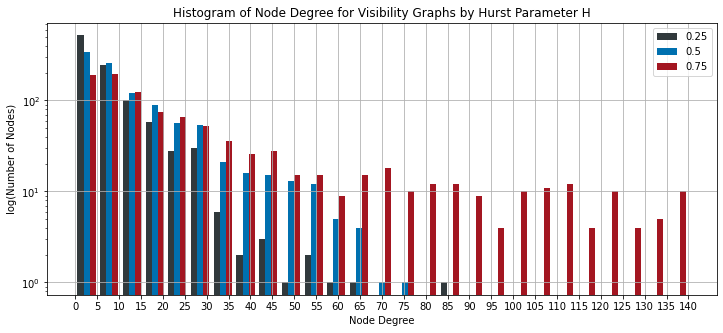

...the persistent series ($H=0.75$, in red above) has many more nodes with degree greater than 75 than does the random series ($H=0.5$, in blue above), and conversely the antipersistent series ($H=0.25$, in black above) has fewer nodes with large degree than does the random series.

# Conclusion

In this notebook, we have introduced the visibility graph, long range dependence and demonstrated a relationship between the degree distribution of the visibility graph and the level of long-range dependence in the time series from which the graph was derived. 

Possible further work includes possibly developing a statistical test for dependence that is based on the degree distribution of the visibility graph, developing a faster implementation for extraction of the visibility graph from large time series and benchmarking the statistical test against those existing in the literature, as well as evaluating the value of $H$ for real-world time series.

# References


[1] Bachelier, L. “Théorie de La Spéculation.” Annales Scientifiques de l’École Normale Supérieure 17 (1900): 21–86. doi:10.24033/asens.476.

[2] Davies, R B & Harte, D S. 1987. "Tests for Hurst Effect". Biometrika 74 (1): 95. doi:10.2307/2336024.

[3] Graves, Timothy et al. 2017. "A Brief History of Long Memory: Hurst, Mandelbrot and the Road to ARFIMA, 1951–1980". Entropy (9). doi:10.3390/e19090437.

[4] Lacasa, L. et al. 2009. "The visibility graph: A new method for estimating the Hurst exponent of fractional Brownian motion". EPL 86 (3): 30001. doi:10.1209/0295-5075/86/30001.

[5] Lacasa, Lucas et al. 2008. "From time series to complex networks: The visibility graph". Proceedings of the National Academy of Sciences 105 (13): 4972–4975. doi:10.1073/pnas.0709247105.

[6] Mandelbrot, Benoit B & Ness, John W Van. 1968. "Fractional Brownian Motions, Fractional Noises and Applications". SIAM Review 10 (4): 422–437. doi:10.1137/1010093.

[7] Tsay, Ruey S. Analysis of Financial Time Series, Third Edition. 3rd ed. Wiley Series in Probability and Statistics. Hoboken, NJ: Wiley, 2010.